# Source Catalogue

Can we use astronomical source catalogues to search for potential hosts, rather than trying to find potential hosts ourselves? This has some advantages:

- We can ignore the potential hosts problem entirely - someone else has already solved it for us!
- We would be in line with other astrophysics research.
- Astronomers who make catalogues are probably better than me at finding potential hosts.
- We can probably get astronomical features associated with each potential host, which may be useful for the classification task.

I think we could use the AllWISE Source Catalog. It seems to cover all of the regions we care about. We need to worry about querying the server too much. In future, we might just be able to download the whole catalogue for the regions we care about, but for now I'll just make sure that all queries to the server are issued manually. This will ensure that I won't hammer the server with requests.

In [76]:
import collections
import io
from pprint import pprint
import sqlite3
import sys
import warnings

import astropy.io.votable
import astropy.wcs
import matplotlib.pyplot
import numpy
import requests
import requests_cache

%matplotlib inline

sys.path.insert(1, '..')
import crowdastro.data
import crowdastro.labels
import crowdastro.rgz_analysis.consensus
import crowdastro.show

warnings.simplefilter('ignore', UserWarning)  # astropy always raises warnings on Windows.

requests_cache.install_cache(cache_name='gator_cache', backend='sqlite', expire_after=None)

## Querying for potential hosts

I'll grab a subject and try and find potential hosts using the AllWISE Source Catalog.

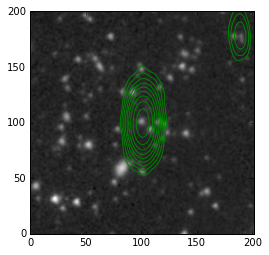

In [5]:
subject = crowdastro.data.db.radio_subjects.find_one({'metadata.survey': 'atlas', 'state': 'complete',
                                                      'zooniverse_id': 'ARG0003r18'})
crowdastro.show.subject(subject)
matplotlib.pyplot.show()

The first question is: Which patch of sky do we query? I know that the image patch is $2 \times 2\ \mbox{arcmin}$, but I also need to know what point it's centred on. Maybe we can get this from the subject itself, or the corresponding FITS file.

In [6]:
pprint(subject['coords'])

[53.538672, -28.405543]


That looks right to me. I think this is RA and DEC, but I don't think I need to care as long as they're in the right order &mdash; the query server is pretty flexible with formats.

The format of a query is:
http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query?[keyword1=value1]&[keyword2=value2]&...[keywordn=valuen]
This should be pretty easy with the `requests` module.

A query requires

- `catalog` &mdash; Julie said to use different catalogues for different subjects. For CDFS, we need `chandra_cat_f05`; for ELAIS S1, we need `elaiss1_cat_f05`. More catalogues are available [here](http://irsa.ipac.caltech.edu/applications/Gator/GatorAid/irsa/catlist.html).
- `spatial` &mdash; the type of spatial query, in our case `box`.
- `objstr` &mdash; centre coordinate.
- `size` &mdash; since we're using box. This is the width of the box in arcseconds (so 120 arcseconds).
- `outfmt` &mdash; the format of the output, for which I will use XML VOTable (`3`) which can be opened with `astropy.io.votable`.

In [7]:
query = {
    'catalog': 'chandra_cat_f05',
    'spatial': 'box',
    'objstr': '{} {}'.format(*subject['coords']),
    'size': '120',
    'outfmt': '3',
}
url = 'http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query'

r = requests.get(url, params=query)

In [8]:
votable = astropy.io.votable.parse_single_table(io.BytesIO(r.content), pedantic=False)

In [9]:
# Pull out the RAs and DECs
ras = votable.array['ra']
decs = votable.array['dec']

# We need to convert to pixels. We can do this with astropy.wcs.
fits = crowdastro.data.get_ir_fits(subject)

In [10]:
wcs = astropy.wcs.WCS(fits.header)
xs, ys = wcs.all_world2pix(ras, decs, 0)

In [11]:
# Let's also find the consensus hosts to compare.
consensus_xs = []
consensus_ys = []
consensus = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
for answer in consensus['answer'].values():
    consensus_xs.append(answer['ir_peak'][0] * 201 / 500 )
    consensus_ys.append(201 - answer['ir_peak'][1] * 201 / 500)

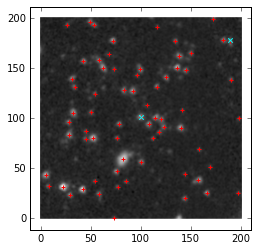

In [12]:
# Plot them!
crowdastro.show.ir(subject)
matplotlib.pyplot.scatter(xs, ys, c='r', marker='+')
matplotlib.pyplot.scatter(consensus_xs, consensus_ys, c='cyan', marker='x')
matplotlib.pyplot.show()

This seems pretty good! We can even get the fluxes for these and have a look at them.

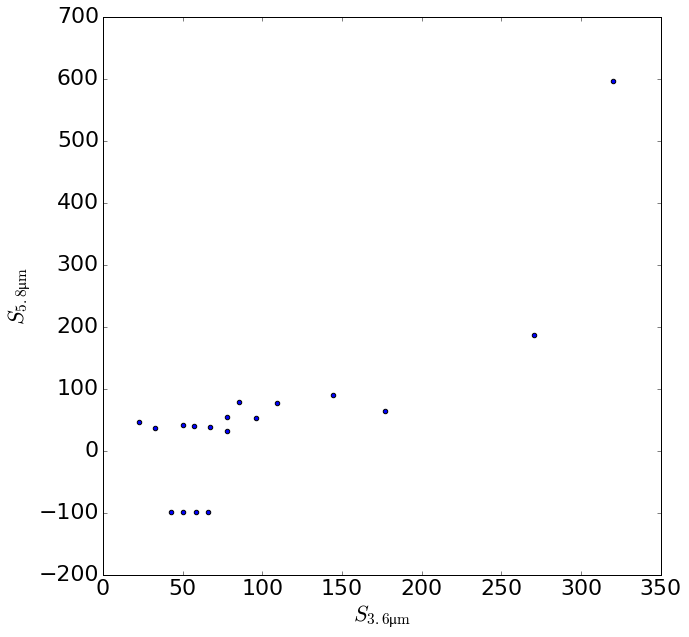

In [25]:
matplotlib.pyplot.figure(figsize=(10, 10))
matplotlib.rcParams.update({'font.size': 22})
xs = votable.array['flux_ap2_36']
ys = votable.array['flux_ap2_58']
matplotlib.pyplot.scatter(xs, ys)
matplotlib.pyplot.xlabel('$S_{3.6 \mathrm{μm}}$')
matplotlib.pyplot.ylabel('$S_{5.8 \mathrm{μm}}$')
matplotlib.pyplot.show()

Now, I want to apply this over the whole ATLAS dataset. I've frozen the ATLAS consensuses in a database, but we'll also need the relevant catalogues - I can't figure out how to download the whole catalogues, so I'll only run this over a hundred or so subjects so I don't hammer the server too hard.

I'll try and see what the fluxes are for objects people click on.

In [99]:
fluxes = []
all_fluxes = []

conn = sqlite3.connect('../crowdastro-data/processed.db')

def append_fluxes(subject):
    if subject['metadata']['source'].startswith('C'):
        # CDFS
        catalog = 'chandra_cat_f05'
    else:
        # ELAIS-S1
        catalog = 'elaiss1_cat_f05'
    
    query = {
        'catalog': catalog,
        'spatial': 'box',
        'objstr': '{} {}'.format(*subject['coords']),
        'size': '120',
        'outfmt': '3',
    }
    url = 'http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query'

    r = requests.get(url, params=query)
    votable = astropy.io.votable.parse_single_table(io.BytesIO(r.content), pedantic=False)
    
    ras = votable.array['ra']
    decs = votable.array['dec']

    # Convert to px.
    fits = crowdastro.data.get_ir_fits(subject)
    wcs = astropy.wcs.WCS(fits.header)
    xs, ys = wcs.all_world2pix(ras, decs, 0)
    
    consensus_xs = []
    consensus_ys = []
    consensus = crowdastro.labels.get_subject_consensus(subject, conn, 'classifications')
    for x, y in consensus.values():
        consensus_xs.append(x)
        consensus_ys.append(y)
    
    for cx, cy in zip(consensus_xs, consensus_ys):
        if cx is None or cy is None:
            continue

        closest = None
        min_distance = float('inf')
    
        for i, x, y in zip(range(len(xs)), xs, ys):
            dist = numpy.hypot(x - cx, y - cy)
            if dist < min_distance:
                closest = (x, y)
                min_distance = dist
        
        flux_36 = votable.array['flux_ap2_36'][i]
        flux_58 = votable.array['flux_ap2_58'][i]
        fluxes.append((flux_36, flux_58))
    
    for flux_36, flux_58 in zip(votable.array['flux_ap2_36'], votable.array['flux_ap2_58']):
        all_fluxes.append((flux_36, flux_58))

In [100]:
for subject in crowdastro.data.get_all_subjects(atlas=True).limit(100):
    append_fluxes(subject)

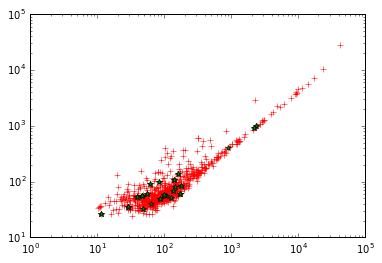

In [101]:
all_fluxes = numpy.array(all_fluxes)
fluxes = numpy.array(fluxes)

matplotlib.pyplot.loglog(all_fluxes[:, 0], all_fluxes[:, 1], c='r', marker='+', linestyle='None')
matplotlib.pyplot.loglog(fluxes[:, 0], fluxes[:, 1], c='g', marker='*', linestyle='None')
matplotlib.pyplot.show()

In [102]:
fluxes

array([[  104.39,    56.32],
       [  104.39,    56.32],
       [   46.27,      nan],
       [   46.27,      nan],
       [   19.77,      nan],
       [   19.77,      nan],
       [   76.16,      nan],
       [   20.11,      nan],
       [   34.79,      nan],
       [   34.79,      nan],
       [  159.98,   138.37],
       [  159.98,   138.37],
       [   29.76,      nan],
       [   62.07,      nan],
       [   10.92,      nan],
       [   10.92,      nan],
       [   10.92,      nan],
       [   10.92,      nan],
       [   23.8 ,      nan],
       [   17.36,      nan],
       [   22.08,      nan],
       [   22.08,      nan],
       [  124.19,    50.43],
       [  124.19,    50.43],
       [   87.5 ,   -99.  ],
       [   87.5 ,   -99.  ],
       [   17.71,      nan],
       [   17.71,      nan],
       [   17.71,      nan],
       [   17.71,      nan],
       [   14.28,      nan],
       [   41.18,      nan],
       [   11.9 ,      nan],
       [   26.54,   -99.  ],
       [   26.

There are a lot of NaNs, which is a bit concerning. Either way, the source catalogue seems to work.